In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns 
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.cross_validation import StratifiedKFold, cross_val_score, KFold
from sklearn.naive_bayes import BernoulliNB
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import make_pipeline, make_union
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn import clone
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.metrics import log_loss
import pickle
import random
from catboost import CatBoostClassifier
import lightgbm as lgb

/home/tu/miniconda3/envs/env36/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


ModuleNotFoundError: No module named 'lightgbm'

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

X_train = train.ix[:, train.columns != 'target']
y_train = train.ix[:, train.columns == 'target']

test_id = test['ID']

X_train = X_train.drop('ID', axis =1)
X_test_w = test.drop('ID', axis =1 )


/home/tu/miniconda3/envs/env36/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  after removing the cwd from sys.path.


In [3]:
# Split training set and test set into 2 part for validation
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.3, random_state = 1)

In [22]:
clf = CatBoostClassifier(n_estimators=2000,learning_rate=0.03, one_hot_max_size = 10)

In [23]:
clf.fit(X_train, y_train)

ValueError: could not convert string to float: 'C'

In [8]:
cat_features = X_train.select_dtypes(include=["object"]).columns

In [9]:
cat_features

Index(['v3', 'v22', 'v24', 'v30', 'v31', 'v47', 'v52', 'v56', 'v66', 'v71',
       'v74', 'v75', 'v79', 'v91', 'v107', 'v110', 'v112', 'v113', 'v125'],
      dtype='object')

In [11]:
a = np.unique(X_train[['v22']].fillna('nan'), return_counts = True)

In [29]:
c22 = pd.DataFrame({ 'values' : a[0], 'counts' : a[1]})

In [106]:
df_91_107 = pd.get_dummies(X_train[['v91', 'v107']])

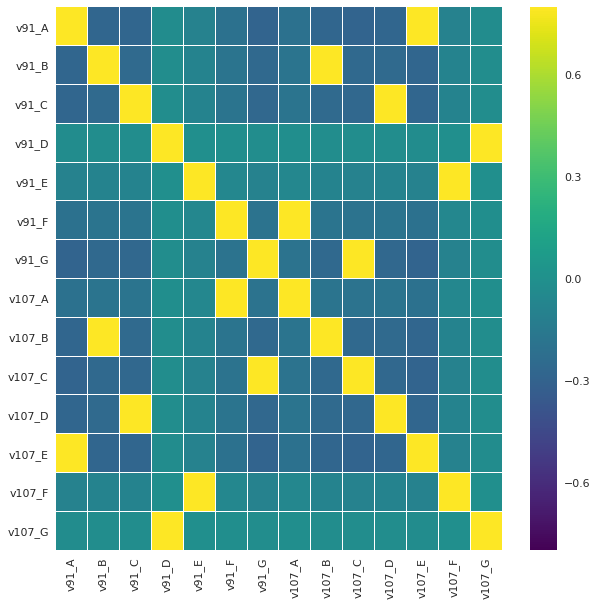

In [33]:
corrMatrix = df_91_107.corr()
sns.set(font_scale = 1.1)
plt.figure(figsize = (10,10))
sns.heatmap(corrMatrix, vmax =.8, linewidths = 0.01, cmap ='viridis', linecolor = 'white')

In [4]:
X_train[['v91', 'v107']].groupby(['v91', 'v107']).count()

,
v91,v107
A,E
B,B
C,D
D,G
E,F
F,A
G,C


In [111]:
X_train[['v71', 'v75']].groupby(['v75', 'v71' ]).count()

Empty DataFrame
Columns: []
Index: [(A, B), (A, C), (A, F), (A, G), (A, I), (A, K), (B, B), (B, C), (B, F), (C, B), (C, C), (C, F), (C, I), (D, C), (D, F)]

In [33]:
# Drop all columns which have percentage of missing values superior 40%
class DropColumnsWithMissingData(BaseEstimator, TransformerMixin):
    
    def __init__(self, thresholds=0.40):
        self.thresholds = thresholds
    
    def fit(self, X, y=None):
        a = X.isnull().mean()
        self.kept_columns = a.index[a < self.thresholds].tolist()
        return self
    
    def transform(self, X):
        return X[self.kept_columns]

In [54]:
class addFeatures:
    
    def __init__(self, n_neighbours=1, max_elts=None):
        """
        add variables which compose 3 features existants giving the highest score of linear regression 
        
        n_neighbours: Number of features to add
        max_elts: Maximum size of a group of linear features
        """
        self.n = n_neighbours
        self.max_elts = max_elts
        self.neighbours = []
        self.clfs = []
        
    def fit(self,X, y):
        if self.max_elts == None:
            self.max_elts = len(X.columns)
        list_vars = list(X.columns)
        random.shuffle(list_vars)
        
        lastscores = np.zeros(self.n) + 1e15

        for elt in list_vars[:self.n]:
            self.neighbours.append([elt])
        list_vars = list_vars[self.n:]
        
        for elt in list_vars:
            indice = 0
            scores = []
            for elt2 in self.neighbours:
                if len(elt2) < self.max_elts:
                    clf = LinearRegression(fit_intercept=False, normalize=True, copy_X=True, n_jobs=-1) 
                    clf.fit(X[elt2 + [elt]], y)
                    scores.append(log_loss(y,clf.predict(X[elt2 + [elt]])))
                    indice = indice + 1
                else:
                    scores.append(lastscores[indice])
                    indice = indice + 1
            gains = lastscores - scores
            if gains.max() > 0:
                temp = gains.argmax()
                lastscores[temp] = scores[temp]
                self.neighbours[temp].append(elt)

        indice = 0
        for elt in self.neighbours:
            clf = LinearRegression(fit_intercept=False, normalize=True, copy_X=True, n_jobs=-1) 
            clf.fit(X[elt], y)
            self.clfs.append(clf)
            indice = indice + 1
                    
    def transform(self, X):
        indice = 0
        for elt in self.neighbours:
            X['_'.join(pd.Series(elt).sort_values().values)] = self.clfs[indice].predict(X[elt])
            indice = indice + 1
        return X
    
    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)

In [55]:
addNearestNeighbourLinearFeatures.fit(X_train,y_train)

TypeError: fit() missing 1 required positional argument: 'y'

In [35]:
class DropColumnsCorrelated(BaseEstimator, TransformerMixin): 
    def __init__(self, ListColumns):
        self.listcolumns = ListColumns
    
    def fit(self, X, y = None):
        return self

    def transform(self, X):
        return X.drop(self.listcolumns , axis = 1)  

In [36]:
X_train_n = DropColumnsWithMissingData(thresholds=0.40).fit_transform(X_train)
#ListColumns = ['v107']
#X_train_n = DropColumnsCorrelated(ListColumns).fit_transform(X_train_n)

categorical_features = X_train_n.select_dtypes(include=["object"]).columns
numerical_features = X_train_n.select_dtypes(exclude=["object"]).columns


In [37]:
class select_features(BaseEstimator, TransformerMixin):
    """
    Select categorical features or numerical features 
    """
    def __init__(self, features):
        self.features = features
         
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.features]

    
class FillMissingValues(BaseEstimator, TransformerMixin):
    """
    Fill missing values 
    'nan' for categorical features
    or -999 for numerical features
    """
    
    def __init__(self, replace_value):
        self.replace_value = replace_value
        # replace_value = 'nan' for filling missing data in categorical features
        # or -999 in numerical features
       
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.fillna(self.replace_value)
    
    
class ColumnApplier(BaseEstimator, TransformerMixin):
    """
    Some sklearn transformers can apply only on ONE column at a time (such as LabelEnconder())
    Wrap them with ColumnApplier to apply on all columns in the dataset
    """

    def __init__(self, underlying):
        self.underlying = underlying
        #TODO: underlying is one model method

    def fit(self, X, y=None):
        m = {}
        X = pd.DataFrame(X)  # TODO: :( reimplement in pure numpy?
        for c in X.columns:
            k = clone(self.underlying) 
            #TODO: clone helps to construct a new estimator with the same parameters.
            #      deep copy of the model in an estimator without actually copying attached data
            
            k.fit(X[c])
            # fit model k for every column in X 
            
            m[c] = k
            # put it in dictionary with column c as key and k as items
        
        self._column_stages = m
        # self.column_stages is a dictionary with column c in X as key and model k.fit as items 
        return self

    def transform(self, X):
        ret = {}
        X = pd.DataFrame(X)
        for c, k in self._column_stages.items():
            ret[c] = k.transform(X[c])
            # ret is a dict which has c as key and k.transform as items
        return pd.DataFrame(ret)[X.columns]  # keep the same order

class TolerantLabelEncoder(LabelEncoder):
    """
    LabelEncoder is not tolerant to unseen values
    """
    def transform(self, y):
        return np.searchsorted(self.classes_, y)
    

In [38]:
class TreatmentSpecialColumns(BaseEstimator, TransformerMixin):
    
    def __init__(self, column = 'v22', threshold = 50):
        self.column = column
        self.threshold = threshold 
        
    def fit(self, X, y = None):
        X_col=X[self.column].fillna('nan')
        values, counts = np.unique(X_col ,return_counts=True)
        counts = {x : y for x, y in zip(values, counts)}
        X[self.column] = X[self.column].apply(lambda x: x if counts.get(x, 0) > self.threshold else 0)
        return self
    
    def transform(self, X):
        return X

In [1]:
# Label Encoding
preproc_le = make_pipeline (
    DropColumnsWithMissingData(thresholds=0.40),
    #TreatmentSpecialColumns(column = 'v22', threshold = 50),
    #DropColumnsCorrelated(ListColumns = ['v107']),
    addNearestNeighbourLinearFeatures(n_neighbours=20, max_elts=3, verbose=True, random_state=1),
    make_union(make_pipeline(
        select_features(categorical_features),
        FillMissingValues('nan'),
        ColumnApplier(TolerantLabelEncoder())
    ),
    make_pipeline(
        select_features(numerical_features),
        FillMissingValues(-999),
        StandardScaler()
        
    )
  )
)

NameError: name 'make_pipeline' is not defined

In [52]:
# one hot Encoding
preproc_ohe = make_pipeline (
    
    DropColumnsWithMissingData(thresholds=0.40),
    #TreatmentSpecialColumns(column = 'v22', threshold = 50),
    #DropColumnsCorrelated(ListColumns = ['v91']),
    make_union(
    make_pipeline(
        select_features(categorical_features),
        FillMissingValues('nan'),
        ColumnApplier(TolerantLabelEncoder()),
        OneHotEncoder(handle_unknown = 'ignore')
    ),
    make_pipeline(
        select_features(numerical_features),
        FillMissingValues(-999),
        StandardScaler()        
    )
  ),
    addNearestNeighbourLinearFeatures(n_neighbours=20, max_elts=3, verbose=True, random_state=1)
)

In [53]:
preproc_ohe.fit(X_train, y_train)

AttributeError: columns not found

In [135]:
class StackedModel(BaseEstimator, TransformerMixin):
    """
    Stacking models
    """
    def __init__(self, delegate):
        self.delegate = delegate

    def fit_transform(self, X, y):
        a = cross_val_predict(self.delegate, X, y, cv= 5, method = 'predict_proba')
        # Generate cross-validated estimates for each input data point
        self.delegate.fit(X, y)
        return a[:,1:]

    def transform(self, X):
        return self.delegate.predict_proba(X)[:,1:]


In [18]:
class KeepBestOnly(BaseEstimator, TransformerMixin):

    def __init__(self, delegates):
        self.delegates = delegates

    def fit_transorm(self, X, y):
        list_model = []
        list_score = []
        for model in self.delegates:
            model.fit(X, y)
            model.predict_proba(X)[:, 1]
            score = model
            list_model.append({score : model})
            list_score.append(score)
        
        max_score = 
        self.best_model = list_model[max]
        return best_prediction  # 1D
        
    def transform(self, X):
        
        return self.best_model.predict_proba(X)

SyntaxError: invalid syntax (<ipython-input-18-33e5d75b6a4a>, line 10)

In [ ]:
model = make_pipeline(
    preproc_ohe,
    make_union(
        make_pipeline(
            KeepBestOnly([
                XGBClassifier(n_estimators=100),
                XGBClassifier(n_estimators=800),
                XGBClassifier(n_estimators = 1000)
            ]),
            StackedModel(),
    ),
    LogisticRegression()
)

In [ ]:
model.fit(X_train, y_train_n)
mode.predict_proba(X_test)

In [116]:
y_train_n = y_train['target'].values
skf = list(StratifiedKFold(y_train_n, n_folds= 5, shuffle=True, random_state=1))

## Optimize hyperparameters of models

In [169]:
def BestParams(X_train, y_train_n, preproc, clfs, skf):
    ListModel = {}
    for clf, params in clfs.items():
        pipeline = make_pipeline(
            preproc, 
            GridSearchCV(
                clf,
                params,
                cv = skf,
                verbose= 1, 
                scoring='log_loss'
                )
            )
        pipeline.fit(X_train, y_train_n)
        ListModel[clf] = pipeline
    return ListModel


In [81]:
clfs = [
    {'clf': XGBClassifier(),
     'params': {
        'n_estimators' : [30, 100, 300, 800],
         'max_depth' : [ 3, 5, 7] 
            }
    },
    {'clf': ExtraTreesClassifier(),
     'params': {
        'n_estimators' : [30, 100, 300, 800],
        'criterion' : ('gini', 'entropy'),
        'max_depth' : [3, 5, 7]
            }
    },
    {'clf': RandomForestClassifier(),
     'params': {
        'n_estimators' : [30, 100, 300, 800],
         'criterion' : ('gini', 'entropy'),
         'max_depth' : [ 3, 5, 7] 
            }
    },
    {'clf':  LogisticRegression(),
     'params': {
        'C' : [0.05, 0.1 , 1, 10], 
        'penalty' : ('l2', 'l1')
            }
    }
]

## Label Encoder

In [ ]:
pipe_label = BestParams(X_train, y_train_n, preproc_label, clfs, skf)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


#### Xgboost

In [ ]:
y_predict_xgb = pipe_label[list(clfs)[0]].predict_proba(X_test)

In [19]:
xgb = pickle.load(open('pipeline_xgb.pkl', 'rb'))

In [21]:
xgb_le = xgb.steps[-1][1]

In [22]:
xgb_le.best_params_

{'max_depth': 7, 'n_estimators': 100}

In [11]:
y_predict_xgb = xgb.predict_proba(X_test)

In [12]:
score_xg = log_loss(y_test, y_predict_xgb[:,1:])
score_xg

0.46646328202720494

#### ExtraTreesClassifier

In [ ]:
y_predict_et = pipe_label[list(clfs)[1]].predict_proba(X_test)

In [24]:
et = pickle.load(open('pipeline_et.pkl', 'rb'))

In [29]:
et_le = et.steps[-1][1]
et_le.best_params_

{'criterion': 'gini', 'max_depth': 7, 'n_estimators': 100}

In [16]:
y_predict_et = et.predict_proba(X_test)

In [17]:
score_et = log_loss(y_test, y_predict_et[:,1:])
score_et

0.51067415633793001

#### LogisticRegression

In [ ]:
y_predict_lg = pipe_label[list(clfs)[1]].predict_proba(X_test)

In [26]:
lg = pickle.load(open('pipeline_lg.pkl', 'rb'))

In [30]:
lg_le = lg.steps[-1][1]
lg_le.best_params_

{'C': 0.1, 'penalty': 'l1'}

In [19]:
y_predict_lg = lg.predict_proba(X_test)

In [20]:
score_lg = log_loss(y_test, y_predict_lg[:,1:])
score_lg

0.48589723267040652

## OneHotEncoder

In [ ]:
pipe_ohe = BestParamsModel(X_train, y_train_n, preproc_ohe, clfs, skf)

#### Xgboost

In [ ]:
y_predict_xgb = pipe_ohe[list(clfs)[0]].predict_proba(X_test)

In [146]:
xgb_ohe = pickle.load(open('xgb_ohe.pkl', 'rb'))

In [147]:
xgb_ohe.steps[-1][1].best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

In [29]:
y_ohe_xgb = xgb_ohe.predict_proba(X_test)

score_xgb_ohe = log_loss(y_test, y_ohe_xgb[:,1:])
score_xgb_ohe

0.46675254991029314

#### ExtraTreesClassifier

In [ ]:
y_predict_et = pipe_ohe[list(clfs)[1]].predict_proba(X_test)

#### LogisticRegression

In [ ]:
y_predict_lg = pipe_ohe[list(clfs)[2]].predict_proba(X_test)

# Best model

In [33]:
min_score = min(score_xg, score_et, score_lg, score_xgb_ohe)
min_score

0.46646328202720494

## Stacking Model

In [158]:
FinalModel = make_pipeline(
     make_union(
        make_pipeline(
        preproc_le,
            make_union(
                StackedModel(XGBClassifier(n_estimators = 100, max_depth = 7)),
                StackedModel(ExtraTreesClassifier(criterion= 'gini', max_depth = 7, n_estimators = 100)),
                StackedModel(LogisticRegression(C = 0.1, penalty = 'l1'))
            )
        ),
         make_pipeline(
         preproc_ohe,
             make_union(
                StackedModel(XGBClassifier(learning_rate = 0.1, max_depth = 5, n_estimators = 100)),
                StackedModel(ExtraTreesClassifier(criterion= 'gini', max_depth = 7, n_estimators = 100)),
                StackedModel(LogisticRegression(C = 0.1, penalty = 'l1'))
            )
        )
     ),
    XGBClassifier()
)

In [159]:
FinalModel.fit(X_train, y_train_n)

Pipeline(steps=[('featureunion', FeatureUnion(n_jobs=1,
       transformer_list=[('pipeline-1', Pipeline(steps=[('pipeline', Pipeline(steps=[('dropcolumnswithmissingdata', DropColumnsWithMissingData(thresholds=0.4)), ('featureunion', FeatureUnion(n_jobs=1,
       transformer_list=[('pipeline-1', Pipeline(ste...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [160]:
y_prediction_last = FinalModel.predict_proba(X_test)
score = log_loss(y_test, y_prediction_last[:,1:])
score

0.46514788342566055